# Introduction to Python for quantitative finance.


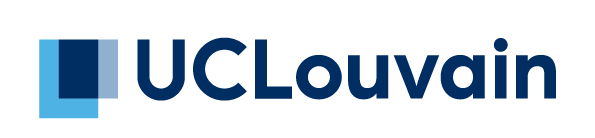



*Author* : Ubeydullah Ozcan, Actuarial consultant at EY (ozcanubey@outlook.com or ubeydullah.ozcan@be.ey.com)

## Course 4 - Efficient frontier and optimal portfolio under risk budget

### Efficient frontier

***Defintion*** : In modern portfolio theory, the efficient frontier (or portfolio frontier) is an investment portfolio which occupies the "efficient" parts of the risk–return spectrum. Formally, it is the set of portfolios which satisfy the condition that no other portfolio exists with a higher expected return but with the same standard deviation of return (i.e., the risk)

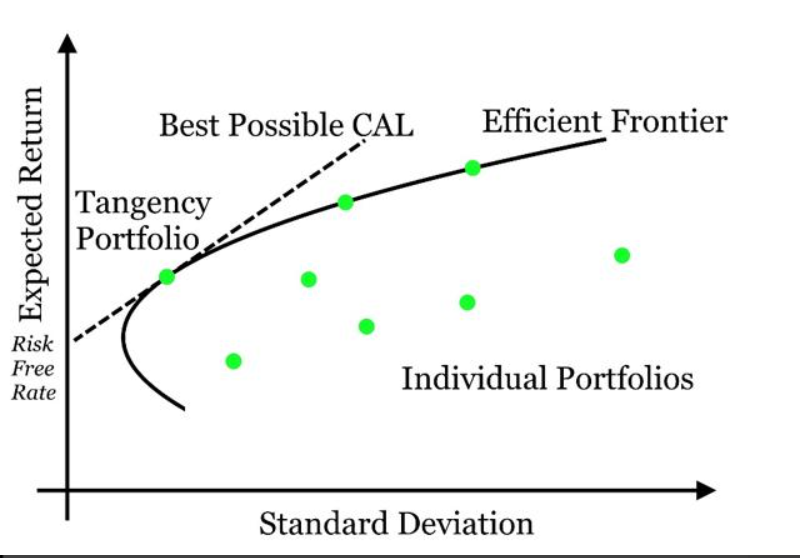




The graph below is the representation in term of risk-return of portfolios and for individual portfolios. The idea behind the efficient frontier is that it is impossible to reach this frontier by investing in indivual assets. 

Now, let's see how this frontier is build.

First, we need to recall the formula that helps us to calculate optimal portfolio and calculate the expected return and variance of optimal portfolio.

### Formulas

#### In absence of risk-free asset
$$w(\gamma) = \frac{1}{\gamma} \Sigma^{-1} (\mu - \lambda(\gamma)e)$$
where $$\lambda(\gamma) = \frac{e^T\Sigma^{-1}\mu - \gamma}{e^T \Sigma^{-1}e}$$

Portfolio's variance : $\sigma_{P}^2 = w^T \Sigma  w$ where $\Sigma$ is the covariance matrix

Portfolio's expected return : $\mu_p = w^T \mu$

#### In presence of a risk-free asset
$$w(\gamma) = \frac{1}{\gamma} \Sigma^{-1} (\mu - re)$$

Portfolio's variance : $\sigma_{P}^2 = w^T \Sigma  w$ where $\Sigma$ is the covariance matrix

Portfolio's expected return : $\mu_p = w^T \mu + (1- w^T e)r$

The efficient frontier is build by calculate a set of $\mu_p$ and $\sigma_p$ for a set of $\gamma$. Let's see how does it work in Python.

### Code

####  1- Needed packages

#### 2 - Inputs

In [1]:
from os import name
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
import pandas as pd
import numpy as np
import datetime
import math

In [2]:
start = datetime.datetime(2018,1,1)
end = datetime.datetime(2020,12,31)
stocks = ['AAPL', 'NVDA', "AMZN"]

#### 3 - Functions

##### 3.1 -  Import weekly stocks price and calculate returns

In [3]:
def Import_stocks(name, start, end):

    n = len(name)
    ptf = pd.DataFrame()
    for i in range(n):
        tmp = web.get_data_yahoo(name[i], start, end, interval = "w")["Close"]
        ptf = pd.concat([ptf, tmp], axis = 1)
    ptf.columns = name
    returns = np.log(ptf/ptf.shift(1))
    returns = returns.dropna()
    return returns

##### 3.2 -  Calculate optimal portfolio

In [4]:
def Ptf(returns, gamma, r):

    m = len(gamma)
    n = len(returns.columns)

    mu = np.transpose(np.array([np.mean(returns)]))
    covariance = np.cov(returns, rowvar = False)/104
    inv_covariance = np.linalg.inv(covariance)
    e = np.full((n,1), 1)
    Lambda = list()
    w = list()
    wr = list()

    for i in range(m):
        Lambda.append((np.transpose(e) @ inv_covariance @ mu - gamma[i])/(np.transpose(e) @ inv_covariance @ e))
        w.append((1/gamma[i]) * inv_covariance @ (mu - Lambda[i]*e))
        wr.append((1/gamma[i]) * inv_covariance @ (mu - r*e))

   
    output = dict()
    output["r"] = r
    output["w"] = w
    output["wr"] = wr
    output["mu"] = mu
    output["Cov"] = covariance
    return output

##### 3.3 - Calculate Efficient Frontier

In [5]:
def Eff_front(W, Wr, mu, cov, r):
    
    n = len(W)
    m = len(W[0])
    e = np.full((m,1), 1)
    mu_P = list()
    sigma_P = list()

    mu_Pr = list()
    sigma_Pr = list()
    
    for i in np.arange(n):
        mu_P.append(np.transpose(W[i]) @ mu)
        sigma_P.append(math.sqrt(np.transpose(W[i]) @ cov @ W[i]))
        mu_Pr.append(np.transpose(Wr[i]) @ mu + (1 - np.transpose(Wr[i]) @ e) * r)
        sigma_Pr.append(math.sqrt(np.transpose(Wr[i]) @ cov @ Wr[i]))
        
        
        
    output = dict()

    output["Ptf return"] = mu_P
    output["Ptf std"] = sigma_P
    
    output["Ptf return free risk asset"] = mu_Pr
    output["Ptf std free rist asset"] = sigma_Pr

    return output

##### 3.4 - Output and plot of efficient frontier

In [6]:
rdt = Import_stocks(name = stocks, start = start, end = end)

W_and_mu = Ptf(returns = rdt, gamma = np.arange(10, 10000,  0.1), r = 0.05)
 
EF = Eff_front(W_and_mu["w"], W_and_mu["wr"], W_and_mu["mu"], W_and_mu["Cov"], W_and_mu["r"])

ef_mu = EF["Ptf return"]
ef_std = EF["Ptf std"]

ef_mu_r = EF["Ptf return free risk asset"]
ef_std_r = EF["Ptf std free rist asset"]

x = np.array(ef_std)
y = np.concatenate(ef_mu, axis = 1)[0]

x2 = np.array(ef_std_r)
y2 = np.concatenate(ef_mu_r, axis = 1)[0]

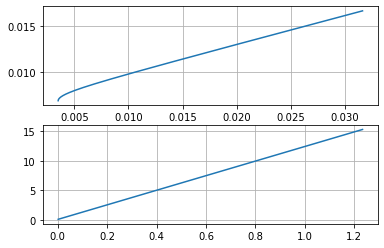

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False)

ax1.plot(x, y, label = "no free risk asset")
ax2.plot(x2, y2, label = "with free risk asset")


ax1.grid()
ax2.grid()

plt.show()

## Sharpe ratio and tangent portfolio

The Sharpe ratio of a portfolio is the excess-rate-of-return per unit of risk
$$ S_x = \frac{\mu_x - r}{\sigma_x} $$
$\mu_x = r$ excess rate-of-return : difference between the portfolio's expected return and the return r of the risk-free asset.

Risk ($\sigma_x$) is measured throuhg standard deviation

   - S < 1 : less interesting than risk-free asset when accounting for risk 
   - S $\geq$ 2 : 1% of volatility generates an excess return of $\geq$ 2%

Here is the way that the weight which maximize the Sharpe ratio is calculate : $$w^{MS} = \frac{\Sigma^{-1}(\mu - re)}{e^T\Sigma^{-1}(\mu - re)} $$

In [8]:
mu = W_and_mu["mu"]
cov = W_and_mu["Cov"]
r = 0.006
def max_SR(mu, cov, r):
    
    m = len(mu)
    e = np.full((m,1), 1)
    
    max_sr = (np.linalg.inv(cov) @ (mu - r*e)) / (np.transpose(e) @ np.linalg.inv(cov) @ (mu - r*e))
    return max_sr


w_maxsr = max_SR(mu, cov, r)

                                                  
    

In [9]:
mu_msr = w_maxsr.transpose() @ mu + r*(1 - w_maxsr.transpose() @ np.full((len(mu),1), 1))
sigma_msr = math.sqrt(w_maxsr.transpose() @ cov @ w_maxsr)

In [10]:
r

0.006

In [11]:
print(float(mu_msr))
print(sigma_msr)

0.008319683605000424
0.005977205422813732


In [12]:
x2 = [0, float(sigma_msr)]
y2 = [r, float(mu_msr)]
slope, intercept = np.polyfit(x2,y2,1)
print(slope)

0.388088319023917


In [23]:
range = np.arange(0, 0.04, 0.001)
rangey = slope * range + r
rangey

array([0.006     , 0.00638809, 0.00677618, 0.00716426, 0.00755235,
       0.00794044, 0.00832853, 0.00871662, 0.00910471, 0.00949279,
       0.00988088, 0.01026897, 0.01065706, 0.01104515, 0.01143324,
       0.01182132, 0.01220941, 0.0125975 , 0.01298559, 0.01337368,
       0.01376177, 0.01414985, 0.01453794, 0.01492603, 0.01531412,
       0.01570221, 0.0160903 , 0.01647838, 0.01686647, 0.01725456,
       0.01764265, 0.01803074, 0.01841883, 0.01880691, 0.019195  ,
       0.01958309, 0.01997118, 0.02035927, 0.02074736, 0.02113544])

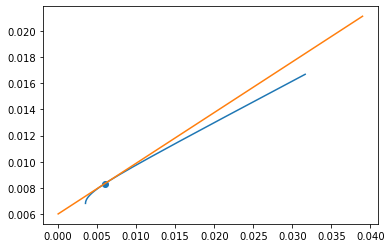

In [24]:
fig, ax = plt.subplots()


ax.plot(x, y)
ax.scatter(sigma_msr, mu_msr)
ax.plot(range, rangey)

plt.show()

### Optimal portfolio given a risk budget
Given a risk budget, this leads to a unique portfolio.

If we want Loss > 25% with less than 1% probability, the portfolio X must obey : 
$$\mu_x + \sigma_x \Phi^{-1}(0.01) \geq -25\% \rightarrow \mu_x \geq -25\% + \sigma_x \Phi^{-1}(0.99) $$ 

In [15]:
from scipy.stats import norm
from scipy.optimize import fsolve
def intersection(sigma_int):
    return (-0.25 + sigma_int * norm.ppf(0.99)) - (slope * sigma_int + r)

In [16]:
sigma_intersection = fsolve(intersection, 0)
sigma_intersection

array([0.13207725])

In [17]:
mu_intersection = -0.25 + sigma_intersection * norm.ppf(0.99)
mu_intersection

array([0.05725764])

In [18]:
x_cml = np.arange(0,0.4,0.05)
y_cml = (x_cml * slope) + r

sigma_i = np.arange(0.01, 0.4, 0.01)
mu_i = -0.25 + sigma_i * norm.ppf(0.99)

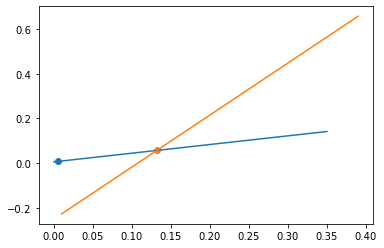

In [19]:
fig, ax = plt.subplots()

ax.plot(x_cml, y_cml)
ax.plot(sigma_i, mu_i)
ax.scatter(sigma_msr, mu_msr)
ax.scatter(sigma_intersection, mu_intersection)


plt.show()

In [20]:
def opt_ptf_risk_budg(gamma):
    ww = (np.linalg.inv(cov) @ (mu - r))/gamma
    mu2 = (ww.T @ mu) + r*(1 - ww.T @ np.full((len(mu), 1), 1))
    return float(mu2) - float(mu_intersection)

In [21]:
opt_gamma = fsolve(opt_ptf_risk_budg, 1)
print("the optimal gamma is ", opt_gamma)

the optimal gamma is  [2.93834333]


In [22]:
print("the optimal portfolio under risk budget is ", (np.linalg.inv(cov) @ (mu - r))/opt_gamma)

the optimal portfolio under risk budget is  [[ 37.36497978]
 [-23.61592929]
 [  8.34777318]]
